# Langgraph 实现 Translation Agent
 

In [5]:
from langchain_core.messages import BaseMessage
! pip install langgraph langsmith langchain-openai


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


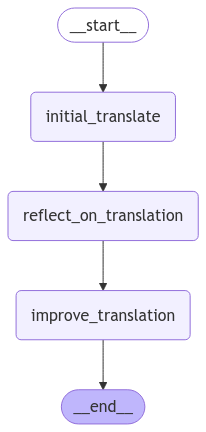

================================ Human Message =================================

静夜思\n 床前明月光\n 疑是地上霜\n 举头望明月\n 低头思故乡\n
================================== Ai Message ==================================

Quiet Night Thoughts

Moonlight before my bed,
Perhaps frost on the ground.
Lifting my head, I gaze at the bright moon,
Lowering it, I think of home.
================================== Ai Message ==================================

1. The title "Quiet Night Thoughts" could be shortened and made more poetic to fit the tone of the poem. Consider "Thoughts on a Quiet Night" or "Reflections on a Silent Night."

2. The phrase "Moonlight before my bed" is accurate but can be improved for better fluency. Consider "Bright moonlight shining before my bed."

3. The line "Perhaps frost on the ground" could be more evocatively translated. Consider "Could it be frost on the ground?"

4. The phrase "Lifting my head, I gaze at the bright moon" is good but slightly less poetic. Consider "I lift my head 

In [6]:
import os
from dotenv import load_dotenv
# langgraph chat
from typing import TypedDict, Annotated, Dict, List
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from IPython.display import Image, display

from langgraph.graph import START, END

# 初始化 langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "default"

# https://smith.langchain.com

# 加载 .env 文件
load_dotenv()
llm = ChatOpenAI(model="gpt-4o", openai_api_key=os.getenv("OPENAI_API_KEY"),
                 openai_api_base=os.getenv("OPENAI_API_BASE"))

source_lang = "Chinese"
target_lang = "English"


class State(TypedDict):
    messages: Annotated[list, add_messages]


def initial_translate(state: State):
    source_text = state["messages"][-1].content
    system_prompt = f"You are an expert linguist, specializing in translation from {source_lang} to {target_lang}."
    translation_prompt = f"""This is an {source_lang} to {target_lang} translation, please provide the {target_lang} translation for this text. \
Do not provide any explanations or text apart from the translation.
{source_lang}: {source_text}

{target_lang}:"""
    messages = [
        ("system", system_prompt),
        ("human", translation_prompt)
    ]
    return {"messages": [llm.invoke(messages)]}


def reflect_on_translation(state: State):
    country = "America"
    source_text = state["messages"][-2].content
    translation_1 = state["messages"][-1].content
    system_message = f"You are an expert linguist specializing in translation from {source_lang} to {target_lang}. \
You will be provided with a source text and its translation and your goal is to improve the translation."

    if country != "":
        reflection_prompt = f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. \
The final style and tone of the translation should match the style of {target_lang} colloquially spoken in {country}.

The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
(iii) style (by ensuring the translations reflect the style of the source text and take into account any cultural context),\n\
(iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

Write a list of specific, helpful and constructive suggestions for improving the translation.
Each suggestion should address one specific part of the translation.
Output only the suggestions and nothing else."""

    else:
        reflection_prompt = f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticisms and helpful suggestions to improve the translation. \

The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
(iii) style (by ensuring the translations reflect the style of the source text and take into account any cultural context),\n\
(iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

Write a list of specific, helpful and constructive suggestions for improving the translation.
Each suggestion should address one specific part of the translation.
Output only the suggestions and nothing else."""

    messages = [
        ("system", system_message),
        ("human", reflection_prompt)
    ]
    return {"messages": [llm.invoke(messages)]}


def improve_translation(state: State):
    source_text = state["messages"][-3].content
    translation_1 = state["messages"][-2].content
    reflection = state["messages"][-1].content

    system_message = f"You are an expert linguist, specializing in translation editing from {source_lang} to {target_lang}."

    prompt = f"""Your task is to carefully read, then edit, a translation from {source_lang} to {target_lang}, taking into
account a list of expert suggestions and constructive criticisms.

The source text, the initial translation, and the expert linguist suggestions are delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT>, <TRANSLATION></TRANSLATION> and <EXPERT_SUGGESTIONS></EXPERT_SUGGESTIONS> \
as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

<EXPERT_SUGGESTIONS>
{reflection}
</EXPERT_SUGGESTIONS>

Please take into account the expert suggestions when editing the translation. Edit the translation by ensuring:

(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules and ensuring there are no unnecessary repetitions), \
(iii) style (by ensuring the translations reflect the style of the source text)
(iv) terminology (inappropriate for context, inconsistent use), or
(v) other errors.

Output only the new translation and nothing else."""

    messages = [
        ("system", system_message),
        ("human", prompt)
    ]
    return {"messages": [llm.invoke(messages)]}


workflow = StateGraph(State)

workflow.add_node(initial_translate)
workflow.add_node(reflect_on_translation)
workflow.add_node(improve_translation)

# 定义有向无环图
workflow.set_entry_point("initial_translate")
workflow.add_edge("initial_translate", "reflect_on_translation")
workflow.add_edge("reflect_on_translation", "improve_translation")
workflow.add_edge("improve_translation", END)
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

user_input = input("输入中翻译英的内容: ")
events = graph.stream({"messages": ("user", user_input)}, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()